<a href="https://colab.research.google.com/github/PeterykSong/DeepLearning_Tutorial/blob/main/tutorial1_1_%EC%86%A1%EC%98%81%EA%B5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense lyaer를 이용하여 (MNIST data, Fashion MNIST data) 분류하기

### key word: pytorch, sgd optimizer, adam optimizer, overfitting, drop out, batch normalization, train/test dataset, loss and accuracy
(key word에 대해서 검색하고 숙지한후 진행하는것을 추천드립니다.)


- 1. optimizer는 SGD,ADAM을 각각사용해보고 비교할것
- 2. overfitting을 방지하기 위한 대표적인 2가지 방법 (Drop out, Batch normalization) 사용하여 각 방법 비교해보기
- 3. 모델 layer수를 1.5배로 늘리고 기존것과 비교해보기
- 4. 비교는 train, test 둘다 loss 와 accuray에 대해서 할것

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# MNIST dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 이미지를 정규화
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.99MB/s]


In [3]:
print("훈련 데이터의 형태:", train_set.data.shape)
print("테스트 데이터의 형태:", test_set.data.shape)
print("훈련 레이블의 형태:", train_set.targets.shape)
print("테스트 레이블의 형태:", test_set.targets.shape)

print("훈련 데이터의 최소값:", train_set.data.min())
print("훈련 데이터의 최대값:", train_set.data.max())

훈련 데이터의 형태: torch.Size([60000, 28, 28])
테스트 데이터의 형태: torch.Size([10000, 28, 28])
훈련 레이블의 형태: torch.Size([60000])
테스트 레이블의 형태: torch.Size([10000])
훈련 데이터의 최소값: tensor(0, dtype=torch.uint8)
훈련 데이터의 최대값: tensor(255, dtype=torch.uint8)


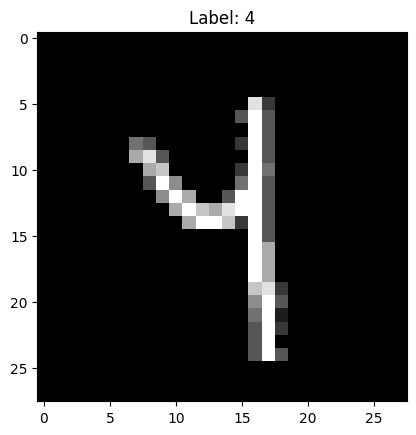

In [4]:
image, label = next(iter(train_loader))
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f"Label: {label[0]}")
plt.show()

# Your code here

In [5]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 입력 레이어
        self.fc2 = nn.Linear(128, 64)        # 은닉 레이어
        self.fc3 = nn.Linear(64, 10)         # 출력 레이어

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 2D 텐서를 1D로 변환
        x = F.relu(self.fc1(x))  # ReLU 활성화 함수
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NeuralNetDropout(nn.Module):
    def __init__(self):
        super(NeuralNetDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout 비율 50%

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout 적용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NeuralNetBatchNorm(nn.Module):
    def __init__(self):
        super(NeuralNetBatchNorm, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.bn1(self.fc1(x)))  # Batch Normalization 적용
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class NeuralNetDeep(nn.Module):
    def __init__(self):
        super(NeuralNetDeep, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 192)  # 128 → 192
        self.fc2 = nn.Linear(192, 128)  # 추가된 레이어
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [15]:
# initialize model


models = {
    "Baseline": NeuralNet,
    "Dropout": NeuralNetDropout,
    "BatchNorm": NeuralNetBatchNorm,
    "Deep": NeuralNetDeep
}

In [7]:
# optimizer setting

optimizers = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001)
}



In [8]:
# define loss function

criterion = nn.CrossEntropyLoss()  # 크로스 엔트로피 손실 함수


In [9]:
# train code here

num_epochs = 10

def train_model(model, optimizer, train_loader, criterion, num_epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    return train_losses, train_accuracies

def evaluate_model(model, test_loader, criterion):
    model.to(device)
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    return avg_loss, accuracy


Using device: cuda

Training Baseline with SGD


/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 1: Loss = 0.4319, Accuracy = 86.88%
Epoch 2: Loss = 0.1776, Accuracy = 94.58%
Epoch 3: Loss = 0.1286, Accuracy = 96.12%
Epoch 4: Loss = 0.1029, Accuracy = 96.75%
Epoch 5: Loss = 0.0861, Accuracy = 97.25%
Epoch 6: Loss = 0.0756, Accuracy = 97.63%
Epoch 7: Loss = 0.0647, Accuracy = 97.87%
Epoch 8: Loss = 0.0620, Accuracy = 97.99%
Epoch 9: Loss = 0.0498, Accuracy = 98.36%
Epoch 10: Loss = 0.0447, Accuracy = 98.48%
Test Loss = 0.0775, Test Accuracy = 97.71%
Training Time: 140.45 seconds ⏳

Training Baseline with Adam
Epoch 1: Loss = 0.3825, Accuracy = 88.66%
Epoch 2: Loss = 0.1810, Accuracy = 94.52%
Epoch 3: Loss = 0.1316, Accuracy = 95.96%
Epoch 4: Loss = 0.1054, Accuracy = 96.69%
Epoch 5: Loss = 0.0929, Accuracy = 97.15%
Epoch 6: Loss = 0.0794, Accuracy = 97.48%
Epoch 7: Loss = 0.0698, Accuracy = 97.76%
Epoch 8: Loss = 0.0600, Accuracy = 98.11%
Epoch 9: Loss = 0.0582, Accuracy = 98.11%
Epoch 10: Loss = 0.0529, Accuracy = 98.26%
Test Loss = 0.1003, Test Accuracy = 97.10%
Training Ti

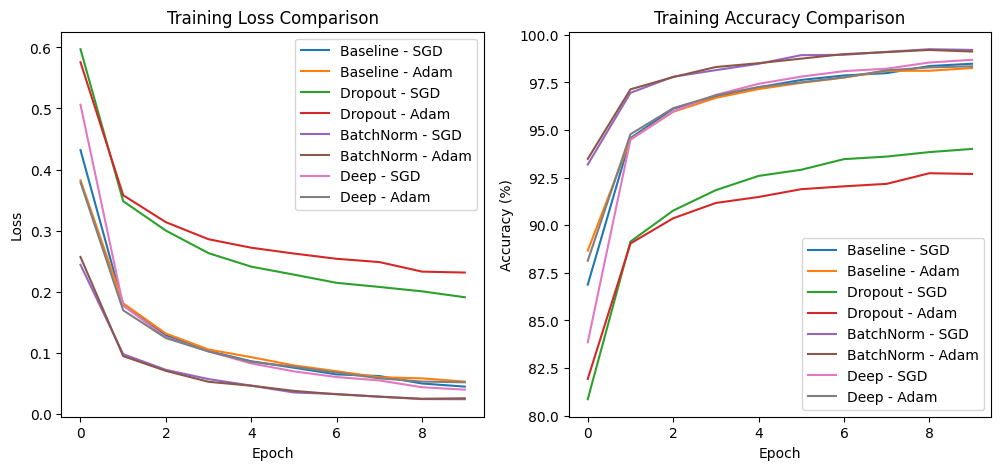

In [17]:
# plot result
import gc
import time  # 시간 측정
import seaborn as sns  # 그래프 시각화

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print the selected device

results = {}

# 모든 모델의 Loss & Accuracy를 하나의 그래프에 저장할 리스트
all_train_losses = {}
all_train_accuracies = {}

for model_name, model_class in models.items():
    for opt_name, opt_func in optimizers.items():
        print(f"\nTraining {model_name} with {opt_name}")

        # 기존 모델 및 메모리 완전 초기화
        if 'model_instance' in locals():
            del model_instance  # 모델 객체 삭제
            gc.collect()  # 가비지 컬렉션 실행

            if torch.cuda.is_available():  # GPU 사용 시만 실행
                torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기
                torch.cuda.reset_max_memory_allocated()  # GPU 메모리 사용 기록 초기화

        # 새로운 모델 및 옵티마이저 생성
        model_instance = model_class()  # 새로운 모델 인스턴스 생성 (CPU)
        model_instance.to(device)  # 이후에 GPU로 이동
        optimizer = opt_func(model_instance)  # 새로운 Optimizer 설정

        # 학습 시간 측정 시작
        start_time = time.time()

        # 학습 실행
        train_losses, train_accuracies = train_model(model_instance, optimizer, train_loader, criterion, num_epochs)

        # 학습 종료 시간 기록
        end_time = time.time()
        training_time = end_time - start_time  # ⏳ 학습 소요 시간 계산

        # 평가 실행
        test_loss, test_accuracy = evaluate_model(model_instance, test_loader, criterion)

        # 결과 저장
        results[(model_name, opt_name)] = {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_time": training_time  # ⏳ 학습 시간 저장
        }

        # 그래프 데이터 저장 (Loss & Accuracy)
        label = f"{model_name} - {opt_name}"
        all_train_losses[label] = train_losses
        all_train_accuracies[label] = train_accuracies

        # 학습 시간 출력
        print(f"Training Time: {training_time:.2f} seconds ⏳")

# Loss & Accuracy 그래프 통합 출력
plt.figure(figsize=(12, 5))

# 🔹 Training Loss Plot
plt.subplot(1, 2, 1)
for label, losses in all_train_losses.items():
    plt.plot(losses, label=label)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 🔹 Training Accuracy Plot
plt.subplot(1, 2, 2)
for label, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=label)
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()




Re-Training BatchNorm with Adam for 20 Epochs
Epoch 1: Loss = 0.2648, Accuracy = 93.26%
Epoch 2: Loss = 0.0955, Accuracy = 97.07%
Epoch 3: Loss = 0.0675, Accuracy = 97.81%
Epoch 4: Loss = 0.0538, Accuracy = 98.22%
Epoch 5: Loss = 0.0444, Accuracy = 98.59%
Epoch 6: Loss = 0.0375, Accuracy = 98.80%
Epoch 7: Loss = 0.0319, Accuracy = 98.94%
Epoch 8: Loss = 0.0285, Accuracy = 99.02%
Epoch 9: Loss = 0.0250, Accuracy = 99.16%
Epoch 10: Loss = 0.0222, Accuracy = 99.26%
Epoch 11: Loss = 0.0228, Accuracy = 99.23%
Epoch 12: Loss = 0.0176, Accuracy = 99.39%
Epoch 13: Loss = 0.0174, Accuracy = 99.42%
Epoch 14: Loss = 0.0167, Accuracy = 99.42%
Epoch 15: Loss = 0.0153, Accuracy = 99.49%
Epoch 16: Loss = 0.0152, Accuracy = 99.48%
Epoch 17: Loss = 0.0126, Accuracy = 99.56%
Epoch 18: Loss = 0.0130, Accuracy = 99.56%
Epoch 19: Loss = 0.0138, Accuracy = 99.50%
Epoch 20: Loss = 0.0115, Accuracy = 99.62%
Test Loss = 0.0701, Test Accuracy = 98.16%
Training Time (20 Epochs): 287.56 seconds

Re-Training Drop

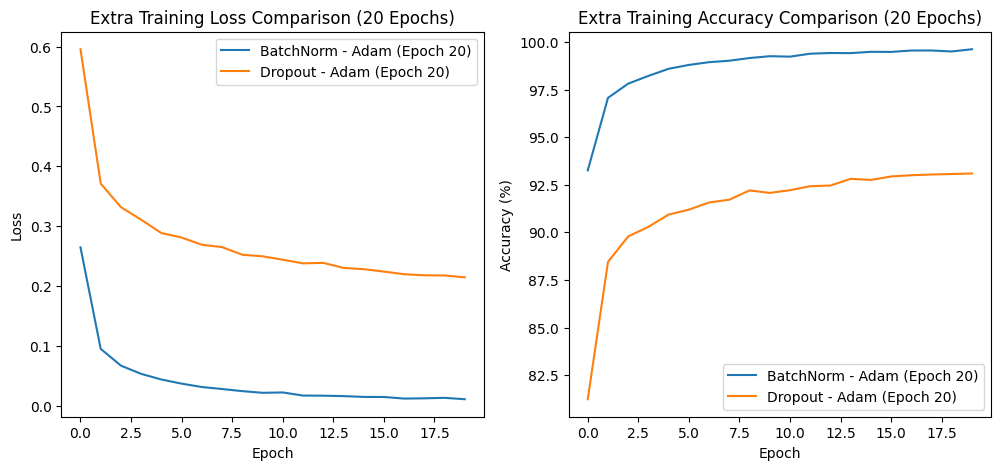

In [18]:
# BatchNorm & Dropout 모델의 Adam 옵티마이저만 Epoch 20으로 추가 학습
extra_results = {}

for model_name in ["BatchNorm", "Dropout"]:
    opt_name = "Adam"  # Adam 옵티마이저만 적용
    if (model_name, opt_name) in results:
        print(f"\nRe-Training {model_name} with {opt_name} for 20 Epochs")

        # 기존 모델 및 메모리 정리
        if 'model_instance' in locals():
            del model_instance  # 모델 객체 삭제
            gc.collect()  # 가비지 컬렉션 실행

            if torch.cuda.is_available():  # GPU 사용 시만 실행
                torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기
                torch.cuda.reset_max_memory_allocated()  # GPU 메모리 사용 기록 초기화

        # 새로운 모델 및 옵티마이저 생성
        model_instance = models[model_name]()  # 모델 생성
        model_instance.to(device)  # GPU로 이동
        optimizer = optimizers[opt_name](model_instance)  # 옵티마이저 생성

        # 학습 시간 측정 시작
        start_time = time.time()

        # 학습 실행 (20 Epoch)
        train_losses, train_accuracies = train_model(model_instance, optimizer, train_loader, criterion, num_epochs=20)

        # 학습 종료 시간 기록
        end_time = time.time()
        training_time = end_time - start_time  # 학습 소요 시간 계산

        # 평가 실행
        test_loss, test_accuracy = evaluate_model(model_instance, test_loader, criterion)

        # 추가 학습 결과 저장
        extra_results[(model_name, opt_name)] = {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_time": training_time  # 학습 시간 저장
        }

        # 학습 시간 출력
        print(f"Training Time (20 Epochs): {training_time:.2f} seconds")

# 추가 학습 결과 비교 그래프 생성
plt.figure(figsize=(12, 5))

# Training Loss Plot
plt.subplot(1, 2, 1)
for (model_name, opt_name), values in extra_results.items():
    plt.plot(values["train_losses"], label=f"{model_name} - {opt_name} (Epoch 20)")
plt.title("Extra Training Loss Comparison (20 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Training Accuracy Plot
plt.subplot(1, 2, 2)
for (model_name, opt_name), values in extra_results.items():
    plt.plot(values["train_accuracies"], label=f"{model_name} - {opt_name} (Epoch 20)")
plt.title("Extra Training Accuracy Comparison (20 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


# Fashion MNIST dataset

In [19]:
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


In [20]:
print("훈련 데이터의 형태:", train_set.data.shape)
print("테스트 데이터의 형태:", test_set.data.shape)
print("훈련 레이블의 형태:", train_set.targets.shape)
print("테스트 레이블의 형태:", test_set.targets.shape)

print("훈련 데이터의 최소값:", train_set.data.min())
print("훈련 데이터의 최대값:", train_set.data.max())

훈련 데이터의 형태: torch.Size([60000, 28, 28])
테스트 데이터의 형태: torch.Size([10000, 28, 28])
훈련 레이블의 형태: torch.Size([60000])
테스트 레이블의 형태: torch.Size([10000])
훈련 데이터의 최소값: tensor(0, dtype=torch.uint8)
훈련 데이터의 최대값: tensor(255, dtype=torch.uint8)


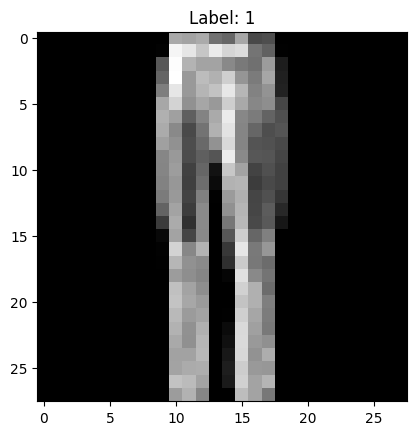

In [21]:
image, label = next(iter(train_loader))
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f"Label: {label[0]}")
plt.show()

# Your code here

Using device: cuda

Training Baseline with SGD
Epoch 1: Loss = 0.5794, Accuracy = 79.25%
Epoch 2: Loss = 0.3957, Accuracy = 85.58%
Epoch 3: Loss = 0.3585, Accuracy = 86.84%
Epoch 4: Loss = 0.3325, Accuracy = 87.76%
Epoch 5: Loss = 0.3133, Accuracy = 88.48%
Epoch 6: Loss = 0.2973, Accuracy = 88.95%
Epoch 7: Loss = 0.2829, Accuracy = 89.50%
Epoch 8: Loss = 0.2726, Accuracy = 89.87%
Epoch 9: Loss = 0.2620, Accuracy = 90.30%
Epoch 10: Loss = 0.2506, Accuracy = 90.52%
Test Loss = 0.3279, Test Accuracy = 88.56%
Training Time: 137.96 seconds ⏳

Training Baseline with Adam
Epoch 1: Loss = 0.5141, Accuracy = 81.38%
Epoch 2: Loss = 0.3759, Accuracy = 86.25%
Epoch 3: Loss = 0.3374, Accuracy = 87.61%
Epoch 4: Loss = 0.3159, Accuracy = 88.30%
Epoch 5: Loss = 0.2974, Accuracy = 88.93%
Epoch 6: Loss = 0.2834, Accuracy = 89.59%
Epoch 7: Loss = 0.2706, Accuracy = 89.98%
Epoch 8: Loss = 0.2600, Accuracy = 90.30%
Epoch 9: Loss = 0.2504, Accuracy = 90.61%
Epoch 10: Loss = 0.2386, Accuracy = 91.06%
Test Lo

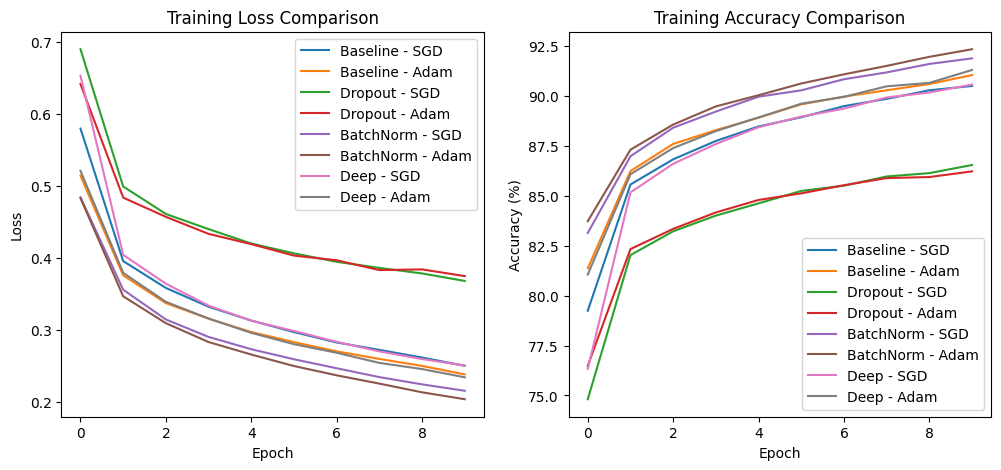

In [22]:
# fastion mnist dataset에도 mnist dataset에서 한것과 같이 수행할것

# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 입력 레이어
        self.fc2 = nn.Linear(128, 64)        # 은닉 레이어
        self.fc3 = nn.Linear(64, 10)         # 출력 레이어

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 2D 텐서를 1D로 변환
        x = F.relu(self.fc1(x))  # ReLU 활성화 함수
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NeuralNetDropout(nn.Module):
    def __init__(self):
        super(NeuralNetDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout 비율 50%

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout 적용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NeuralNetBatchNorm(nn.Module):
    def __init__(self):
        super(NeuralNetBatchNorm, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.bn1(self.fc1(x)))  # Batch Normalization 적용
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class NeuralNetDeep(nn.Module):
    def __init__(self):
        super(NeuralNetDeep, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 192)  # 128 → 192
        self.fc2 = nn.Linear(192, 128)  # 추가된 레이어
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# initialize model
models = {
    "Baseline": NeuralNet,
    "Dropout": NeuralNetDropout,
    "BatchNorm": NeuralNetBatchNorm,
    "Deep": NeuralNetDeep
}

# initialize optimizers
optimizers = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001)
}


# define loss function
criterion = nn.CrossEntropyLoss()  # 크로스 엔트로피 손실 함수

# train code here
num_epochs = 10

def train_model(model, optimizer, train_loader, criterion, num_epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    return train_losses, train_accuracies

def evaluate_model(model, test_loader, criterion):
    model.to(device)
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    return avg_loss, accuracy

    # plot result
import gc
import time  # 시간 측정
import seaborn as sns  # 그래프 시각화

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print the selected device

results = {}

# 모든 모델의 Loss & Accuracy를 하나의 그래프에 저장할 리스트
all_train_losses = {}
all_train_accuracies = {}

for model_name, model_class in models.items():
    for opt_name, opt_func in optimizers.items():
        print(f"\nTraining {model_name} with {opt_name}")

        # 기존 모델 및 메모리 완전 초기화
        if 'model_instance' in locals():
            del model_instance  # 모델 객체 삭제
            gc.collect()  # 가비지 컬렉션 실행

            if torch.cuda.is_available():  # GPU 사용 시만 실행
                torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기
                torch.cuda.reset_max_memory_allocated()  # GPU 메모리 사용 기록 초기화

        # 새로운 모델 및 옵티마이저 생성
        model_instance = model_class()  # 새로운 모델 인스턴스 생성 (CPU)
        model_instance.to(device)  # 이후에 GPU로 이동
        optimizer = opt_func(model_instance)  # 새로운 Optimizer 설정

        # 학습 시간 측정 시작
        start_time = time.time()

        # 학습 실행
        train_losses, train_accuracies = train_model(model_instance, optimizer, train_loader, criterion, num_epochs)

        # 학습 종료 시간 기록
        end_time = time.time()
        training_time = end_time - start_time  # ⏳ 학습 소요 시간 계산

        # 평가 실행
        test_loss, test_accuracy = evaluate_model(model_instance, test_loader, criterion)

        # 결과 저장
        results[(model_name, opt_name)] = {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_time": training_time  # ⏳ 학습 시간 저장
        }

        # 그래프 데이터 저장 (Loss & Accuracy)
        label = f"{model_name} - {opt_name}"
        all_train_losses[label] = train_losses
        all_train_accuracies[label] = train_accuracies

        # 학습 시간 출력
        print(f"Training Time: {training_time:.2f} seconds ⏳")

# Loss & Accuracy 그래프 통합 출력
plt.figure(figsize=(12, 5))

# 🔹 Training Loss Plot
plt.subplot(1, 2, 1)
for label, losses in all_train_losses.items():
    plt.plot(losses, label=label)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 🔹 Training Accuracy Plot
plt.subplot(1, 2, 2)
for label, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=label)
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()



Re-Training BatchNorm with Adam for 30 Epochs
Epoch 1: Loss = 0.4788, Accuracy = 83.91%
Epoch 2: Loss = 0.3436, Accuracy = 87.44%
Epoch 3: Loss = 0.3083, Accuracy = 88.60%
Epoch 4: Loss = 0.2814, Accuracy = 89.50%
Epoch 5: Loss = 0.2650, Accuracy = 90.04%
Epoch 6: Loss = 0.2477, Accuracy = 90.73%
Epoch 7: Loss = 0.2358, Accuracy = 91.18%
Epoch 8: Loss = 0.2245, Accuracy = 91.63%
Epoch 9: Loss = 0.2127, Accuracy = 92.06%
Epoch 10: Loss = 0.2047, Accuracy = 92.33%
Epoch 11: Loss = 0.1911, Accuracy = 92.72%
Epoch 12: Loss = 0.1874, Accuracy = 92.86%
Epoch 13: Loss = 0.1778, Accuracy = 93.33%
Epoch 14: Loss = 0.1719, Accuracy = 93.53%
Epoch 15: Loss = 0.1666, Accuracy = 93.66%
Epoch 16: Loss = 0.1580, Accuracy = 94.10%
Epoch 17: Loss = 0.1515, Accuracy = 94.26%
Epoch 18: Loss = 0.1467, Accuracy = 94.51%
Epoch 19: Loss = 0.1424, Accuracy = 94.61%
Epoch 20: Loss = 0.1346, Accuracy = 94.90%
Epoch 21: Loss = 0.1343, Accuracy = 94.94%
Epoch 22: Loss = 0.1302, Accuracy = 95.09%
Epoch 23: Loss =

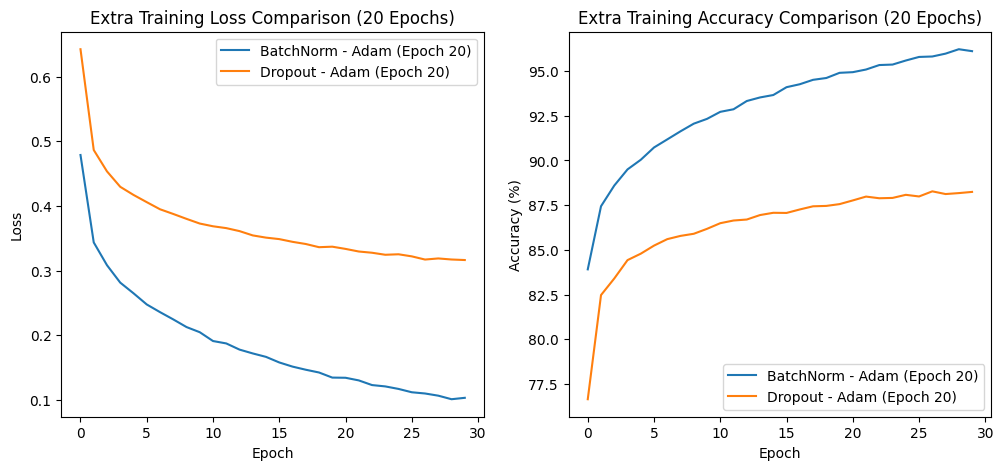

In [24]:
# BatchNorm & Dropout 모델의 Adam 옵티마이저만 Epoch 30으로 추가 학습
extra_results = {}

for model_name in ["BatchNorm", "Dropout"]:
    opt_name = "Adam"  # Adam 옵티마이저만 적용
    if (model_name, opt_name) in results:
        print(f"\nRe-Training {model_name} with {opt_name} for 30 Epochs")

        # 기존 모델 및 메모리 정리
        if 'model_instance' in locals():
            del model_instance  # 모델 객체 삭제
            gc.collect()  # 가비지 컬렉션 실행

            if torch.cuda.is_available():  # GPU 사용 시만 실행
                torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기
                torch.cuda.reset_max_memory_allocated()  # GPU 메모리 사용 기록 초기화

        # 새로운 모델 및 옵티마이저 생성
        model_instance = models[model_name]()  # 모델 생성
        model_instance.to(device)  # GPU로 이동
        optimizer = optimizers[opt_name](model_instance)  # 옵티마이저 생성

        # 학습 시간 측정 시작
        start_time = time.time()

        # 학습 실행 (20 Epoch)
        train_losses, train_accuracies = train_model(model_instance, optimizer, train_loader, criterion, num_epochs=30)

        # 학습 종료 시간 기록
        end_time = time.time()
        training_time = end_time - start_time  # 학습 소요 시간 계산

        # 평가 실행
        test_loss, test_accuracy = evaluate_model(model_instance, test_loader, criterion)

        # 추가 학습 결과 저장
        extra_results[(model_name, opt_name)] = {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_time": training_time  # 학습 시간 저장
        }

        # 학습 시간 출력
        print(f"Training Time (20 Epochs): {training_time:.2f} seconds")

# 추가 학습 결과 비교 그래프 생성
plt.figure(figsize=(12, 5))

# Training Loss Plot
plt.subplot(1, 2, 1)
for (model_name, opt_name), values in extra_results.items():
    plt.plot(values["train_losses"], label=f"{model_name} - {opt_name} (Epoch 20)")
plt.title("Extra Training Loss Comparison (20 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Training Accuracy Plot
plt.subplot(1, 2, 2)
for (model_name, opt_name), values in extra_results.items():
    plt.plot(values["train_accuracies"], label=f"{model_name} - {opt_name} (Epoch 20)")
plt.title("Extra Training Accuracy Comparison (20 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()
